# Preprocessing and Dimensionality Reduction

In [1]:
#   packages
import gc
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import notebook

import re

import pickle

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer

## Clusterizer
from sklearn.cluster import KMeans

#   my packages
from preProcessing import textProcessing

# Flat clustering

In [2]:
#   import wikipediaapi
#   wikiAPI = wikipediaapi.Wikipedia('en')
#   
#   articles=['Mathematics', 'Physics', 'Statistics','Artificial intelligence'
#   , 'Blues', 'Jazz', 'Rock and roll', 'Heavy metal'
#   , 'Soccer', 'Basketball', 'Rugby', 'Volleyball', 'Football'
#   , 'European Central Bank', 'European Parliament', 'European Council'
#   , 'Council of the European Union', 'European Commission'
#   , 'European Court of Justice', 'European Court of Auditors'
#   ]
#   
#   wiki_lst=[]
#   title=[]
#   for article in articles:
#       print("loading content: ",article)
#       wiki_lst.append(wikiAPI.page(article).text)
#       title.append(article)
#   
#   df = pd.DataFrame(wiki_lst, columns=["wiki_lst"])
#   df["title"] = title
#   
#   print(f"Articles loaded : {len(wiki_lst)}")
#   
#   textProc = textProcessing(base_form="lemma"
#   , pos_filter=['NOUN', 'ADV', 'ADJ', 'VERB'], save_words=["not"]
#   , clean_all=True, ngram=1)
#   
#   docs = []
#   data = notebook.tqdm(list(df.iterrows()))
#   for i, row in data:
#       tokens = textProc.filteredToken(row.wiki_lst)
#       docs.append(tokens)
#   
#   df["tokens"] = docs
#   df["preProc"] = df["tokens"].str.join(" ")
#   
#   df.to_pickle(os.path.join("data", "cleaned_wiki.pkl"))

In [3]:
cleanDF = pd.read_pickle(os.path.join("data", "cleaned_wiki.pkl"))
cleanDF.head()

,wiki_lst,title,tokens,preProc
0,"Mathematics (from Greek: μάθημα, máthēma, 'kno...",Mathematics,"[knowledge, study, learn, area, knowledge, inc...",knowledge study learn area knowledge include s...
1,Physics is the natural science that studies ma...,Physics,"[physics, natural, science, study, matter, fun...",physics natural science study matter fundament...
2,Statistics is the discipline that concerns the...,Statistics,"[statistic, discipline, concern, collection, o...",statistic discipline concern collection organi...
3,Artificial intelligence (AI) is intelligence d...,Artificial intelligence,"[artificial, intelligence, intelligence, demon...",artificial intelligence intelligence demonstra...
4,Blues is a music genre and musical form which ...,Blues,"[blue, music, genre, musical, form, originate,...",blue music genre musical form originate 1860 r...


In [4]:
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(cleanDF.preProc).toarray()
X_tfidf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00661685, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Selecting best K

#### using K-means++ with different ‘K’s:
    - Higher Silhouette Coefficient score relates to a model with better defined clusters
    - Higher Calinski-Harabasz score relates to a model with better defined clusters

100%|██████████| 8/8 [00:01<00:00,  6.80it/s]


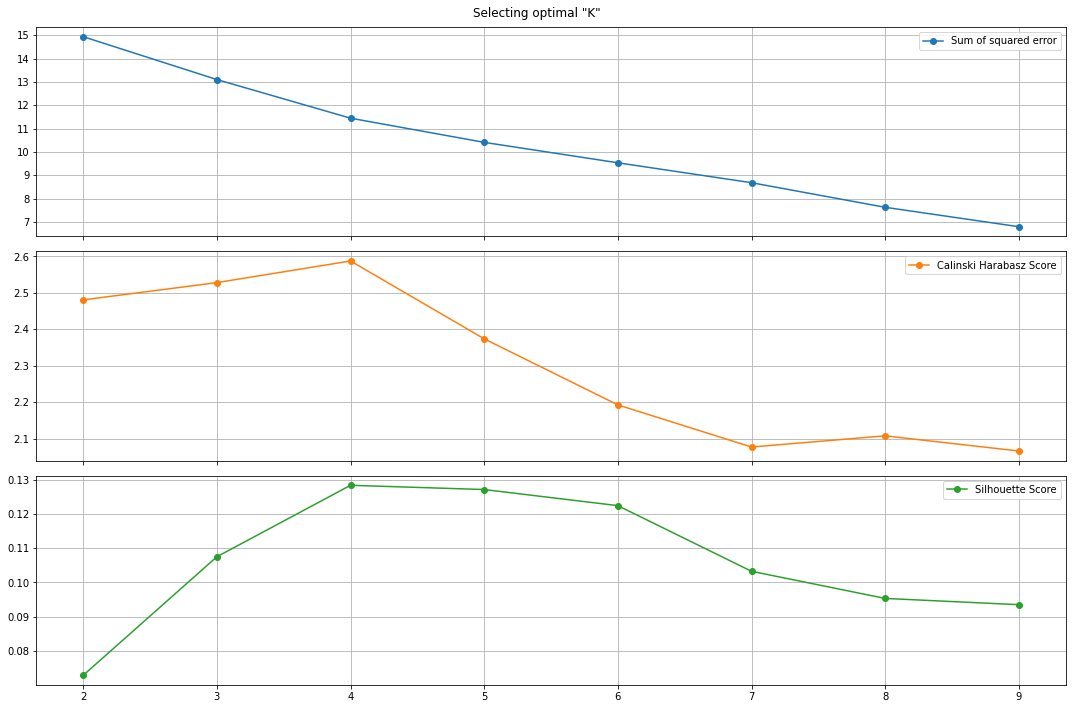

In [5]:
gc.collect()

dataToCluster=X_tfidf

search_range = range(2, 10)
report = {}
for k in tqdm(search_range):
    temp_dict = {}
    kmeans = KMeans(init='k-means++',
                    algorithm='auto',
                    n_clusters=k,
                    max_iter=300,
                    random_state=1,
                    verbose=0).fit(dataToCluster)
    inertia = kmeans.inertia_
    temp_dict['Sum of squared error'] = inertia #   Elbow method
    try:
        cluster = kmeans.predict(dataToCluster)
        chs = metrics.calinski_harabasz_score(dataToCluster, cluster)
        ss = metrics.silhouette_score(dataToCluster, cluster)
        temp_dict['Calinski Harabasz Score'] = chs
        temp_dict['Silhouette Score'] = ss
        report[k] = temp_dict
    except:
        report[k] = temp_dict

report_df = pd.DataFrame(report).T
report_df.plot(figsize=(15, 10),
               xticks=search_range,
               grid=True,
               title=f'Selecting optimal "K"',
               subplots=True,
               marker='o',
               sharex=True)
plt.tight_layout()

In [6]:
wiki_lst_preProc = cleanDF.preProc
title = cleanDF.title
n_clusters_=4
model = KMeans(n_clusters=n_clusters_, init='k-means++', max_iter=300, n_init=10)
model.fit(dataToCluster)
labels=model.labels_
wiki_cl=pd.DataFrame(list(zip(title,labels)),columns=['title','cluster'])
print(wiki_cl.sort_values(by=['cluster']))

                            title  cluster
0                     Mathematics        0
1                         Physics        0
2                      Statistics        0
3         Artificial intelligence        0
12                       Football        1
11                     Volleyball        1
10                          Rugby        1
8                          Soccer        1
9                      Basketball        1
6                   Rock and roll        2
5                            Jazz        2
4                           Blues        2
7                     Heavy metal        2
18      European Court of Justice        3
13          European Central Bank        3
14            European Parliament        3
15               European Council        3
16  Council of the European Union        3
17            European Commission        3
19     European Court of Auditors        3


Cluster: 0
Titles
            Mathematics
                Physics
             Statistics
Artificial intelligence


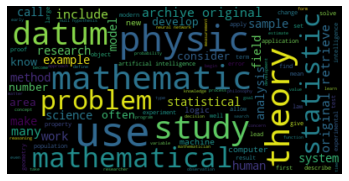

Cluster: 1
Titles
    Soccer
Basketball
     Rugby
Volleyball
  Football


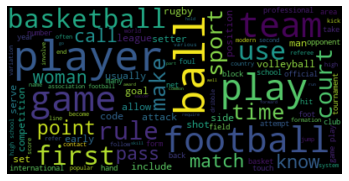

Cluster: 2
Titles
        Blues
         Jazz
Rock and roll
  Heavy metal


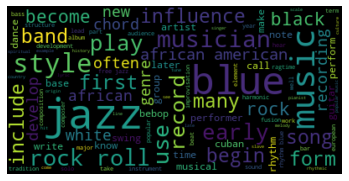

Cluster: 3
Titles
        European Central Bank
          European Parliament
             European Council
Council of the European Union
          European Commission
    European Court of Justice
   European Court of Auditors


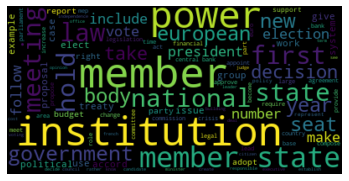

In [7]:
from wordcloud import WordCloud

result=pd.DataFrame({'cluster':labels,'wiki':wiki_lst_preProc})
for k in range(0,n_clusters_):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(text)
    print('Cluster: {}'.format(k))
    print('Titles')
    titles=wiki_cl[wiki_cl.cluster==k]['title']
    print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()